In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

from models.FaceRWKV import FaceRWKV, RWKVConfig
from data.Dataset import CAERSRDataset

In [2]:
data = CAERSRDataset("./data/CAER-S/train")

In [3]:
print(data.class_dict)

{'Disgust': 1}


In [4]:
x ,y= data.__getitem__(3)
print(x.shape)
print(y.shape)


torch.Size([3, 400, 536])
torch.Size([1])


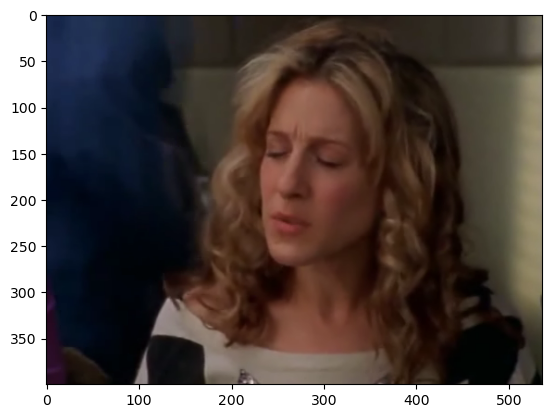

torch.Size([3, 400, 536])


In [5]:
#plot x in matplot
import matplotlib.pyplot as plt
#x = x/x.max()
plt.imshow(  x.permute(1, 2, 0)  )
plt.show()
print(x.shape)

In [6]:

# RWKV       : our new model - fastest when ctx_len is long - VRAM friendly - good performance
# MHA_rotary : usual MultiheadAttention+Rotary+GeGLU - not as good
# MHA_shift  : with time-shift - good performance
# MHA_pro    : slow (lots of tricks) - VRAM hungry - very good performance
model_type = 'RWKV'

# datafile = u"V:\\NLP\\text8"
# datafile = u"V:\\NLP\\enwik8"
datafile = u"V:\\NLP\\simplebooks\\simplebooks-92-raw\\train.txt"
datafile_encoding = 'utf-8'
# datafile = u"D:\\NLP-Data\\ww100M.txt"
# datafile = u"D:\\NLP-Data\\__2019.txt"
# datafile = u"Y:\\BlinkNLP\\_txt_\\txt\\_all.txt"
# datafile = u"V:\\NLP\\enwik8-shift-300.bpe"
# datafile_encoding = 'utf-16'
# datafile = u"V:\\NLP\\simplebooks-shift-utf32.word"
# datafile_encoding = 'utf-32'

datafile_type = 0 # use 0 for char-level english. use 1 for chinese. only affects some RWKV hyperparametrs 

#################################### VERY IMPORTANT ####################################
epoch_save_frequency = 10                            # 0 = never, 1 = every 'epoch', 2 = every two 'epoch', etc.
epoch_save_path = 'trained-'

batch_size = 32                                     # if you see "CUDA out of memory", reduce this.
                                                     # if you have good GPU, increase this.
                                                     # use GPU-Z to find the highest value for your VRAM.

n_epoch = 100                                        # the 'epoch' here is actually very short (and of fixed length)
########################################################################################

model_level = 'character' # 'character' (recommended) or 'word'

ctx_len = 256 # context length, try 512 or 1024 if you have good GPU
n_layer = 6   # try 12 for 100M, 24 for 300M
n_head = 8    # try 12 for 100M, 16 for 300M

n_embd = n_head * 64
n_attn = n_embd
n_ffn = n_embd

lr_init = 6e-4 if model_type == 'RWKV' else 4e-4    # RWKV can use higher lr.  8e-4 = 0.0008   4e-4 = 0.0004
lr_final = 4e-5

betas = (0.9, 0.99) if model_type == 'RWKV' else (0.9, 0.99)
eps = 4e-9
weight_decay = 0 if model_type == 'RWKV' else 0.01  # wd is not useful when we have enough data

epoch_length_fixed = 10000                          # make an 'epoch' very short, so we can see the training progress

######## special hyperparameters for RWKV model ########
rwkv_emb_scale = 0.4                                # scale of initial embedding. 0.4 is a good choice
rwkv_tiny_attn = 0#64 if (datafile_type == 0 and ctx_len > 600) else 0 # extra tiny attention dim, useful for long ctx char-level english
rwkv_tiny_head = 1                                  # 1 is good enough. 8 is slow
# n_side_proj = 512  

In [7]:
config = RWKVConfig()

In [8]:
model = FaceRWKV(config)

In [9]:
# create new random x
x = torch.rand(1, 3, 256, 256)
#x = torch.rand(1, 3, 1024, 1024)

    def __getitem__(self, idx):
        # cheat: pick a random spot in dataset
        i = np.random.randint(0, len(self.data) - (self.ctx_len + 1))
        chunk = self.data[i:i+self.ctx_len+1]
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long,
                         device=torch.device('cuda'))
        y = torch.tensor(dix[1:], dtype=torch.long,
                         device=torch.device('cuda'))
        return x, y
        ## Contextlength problem...
        

Solution for context len probelm (temporary)
- Calc patch size so that the context len is less eq than 1024 or 512 (around 16 or 32)
- better solution? Use pretrained conv net to aggregate to a smaller fature map with unifrom size for all input, then feed to rwkv -> TODO 


In [10]:
output = model(x)

x torch.Size([1, 256, 768])


x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])
x torch.Size([1, 256, 768])


In [11]:
print(output.shape)

torch.Size([1, 10])
